In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import sys

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import transforms as T
from torchvision.datasets.mnist import MNIST

In [2]:
def patchify(images, n_patches):
    N, C, H, W = images.shape

    assert H == W, f"Expected square image, got image of shape ({H}, {W}) instead."

    patches = torch.zeros(N, n_patches ** 2, H * W * C // n_patches ** 2)
    patch_size = H // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

In [3]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (2*j / d))) if j % 2 == 0 else np.cos(i / (10000 ** (2*j/d)))
    return result

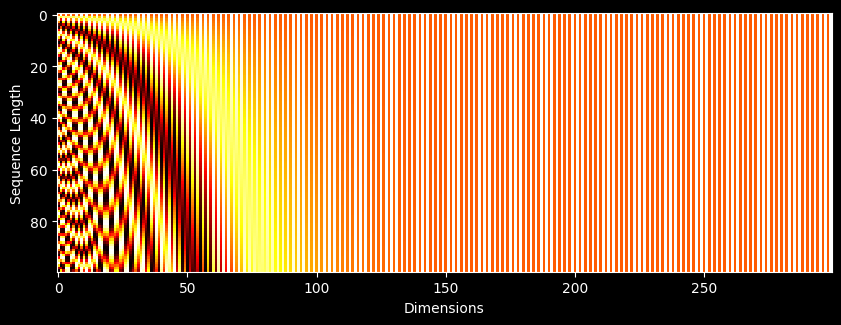

In [4]:
plt.figure(figsize=(10, 4))
plt.imshow(get_positional_embeddings(100, 300), cmap='hot', interpolation='nearest')
plt.xlabel('Dimensions')
plt.ylabel('Sequence Length')
plt.show()

In [5]:
class MSA_MNIST(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MSA_MNIST, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimensions {d} into {n_heads} heads."

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequence has shape (N, seq_length, token_dim)
        # We go into shape   (N, seq_length, token_dim / n_heads)
        # And come back to   (N, seq_length, item_dim) (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head*self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

In [6]:
class ViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(ViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MSA_MNIST(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        return out

In [13]:
class ViT_MNIST(nn.Module):
    def __init__(self, chw=(1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super class Constructor
        super(ViT_MNIST, self).__init__()

        # Attributes
        self.chw = chw # (C, H, W)
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # Input and Patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches."
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches."
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1. Linear Mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2. Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3. Positional Embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)

        # 4. Transformer encoder blocks
        self.blocks = nn.ModuleList([ViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])

        # 5. Classification MLP
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d)
        )

    def forward(self, images):
        # Dividing images into patches
        N, C, H, W = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)

        # Running Linear Layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(N, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(N, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        # Getting the classification token only
        out = out[:, 0]

        return self.mlp(out)  # Map the output dimension, output category distribution

In [14]:
def main():
    # Loading the data
    transform = T.ToTensor()

    train_set = MNIST(root='./../datasets', train=True, download=True, transform=transform)
    test_set = MNIST(root='./../datasets', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
    test_loader = DataLoader(test_set, shuffle=True, batch_size=128)

    # Defining model and training options
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
    model = ViT_MNIST((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)
    N_EPOCHS = 10
    LR = 0.01
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss().to(device)


    # Training Loop
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []

    for epoch in range(N_EPOCHS):
        batch_loss = []
        batch_acc = []
        for count, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)

            # Forward pass
            yHat = model(X)

            # Loss function
            loss = criterion(yHat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute and Store losses and accuracy from this batch
            batch_loss.append(loss.item())
            batch_acc.append(torch.mean((torch.argmax(yHat, axis=1) == y).float()).item()*100)

            msg = "Epoch {}/{}, Batch {}/{}".format(epoch+1, N_EPOCHS, count, len(train_loader))
            sys.stdout.write('\r' + msg)

        # Compute and Store average loss across batches
        train_loss.append(np.mean(batch_loss))

        # Compute and Store average training accuracy
        train_acc.append(np.mean(batch_acc))

        # Test data
        with torch.no_grad():
            batch_loss = []
            batch_acc = []
            for count, (X, y) in enumerate(test_loader):
                X, y = X.to(device), y.to(device)

                # Forward pass
                yHat = model(X)

                # Loss function
                loss = criterion(yHat, y)

                # Compute and Store losses and accuracy from this batch
                batch_loss.append(loss.item())
                batch_acc.append(torch.mean((torch.argmax(yHat, axis=1) == y).float()).item()*100)

                msg = "Epoch {}/{}, Batch {}".format(epoch+1, N_EPOCHS, count, len(test_loader))
                sys.stdout.write('\r' + msg)

        # Compute and Store average loss across batches
        test_loss.append(np.mean(batch_loss))

        # Compute and Store test accuracy
        test_acc.append(np.mean(batch_acc))

    return model, train_loss, test_loss, train_acc, test_acc

In [15]:
model, train_loss, test_loss, train_acc, test_acc = main()

Using device:  cuda:0 (Tesla T4)
Epoch 10/10, Batch 78

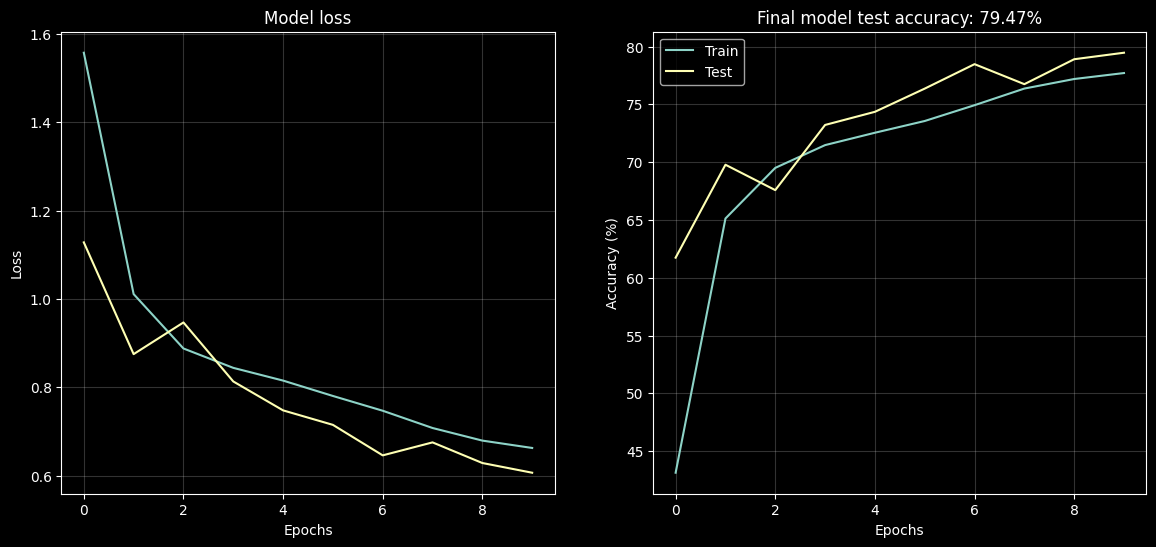

In [16]:
# Visualize the performance
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].plot(train_loss, label='Train')
ax[0].plot(test_loss, label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
# ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')
ax[0].grid(alpha=0.2)

ax[1].plot(train_acc,label='Train')
ax[1].plot(test_acc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
# ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {test_acc[-1]:.2f}%')
ax[1].legend()
ax[1].grid(alpha=0.2)

plt.show()